In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import copy 
#
from matplotlib import gridspec
from backtesting import Backtest, Strategy

C:\Users\SHIHYU\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def get_historical_data(ticker, period):
    d = yf.Ticker(ticker)
    df = d.history(period=period)
    df.columns = df.columns.str.lower()
    df.columns = pd.Series(df.columns).str.capitalize().values
    return df.dropna()

In [119]:
_df = get_historical_data('2454.TW', '8y')
_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2014-05-12,380.612849,380.612849,370.834258,371.210358,8660000,0.0,0
2014-05-13,373.090860,377.604056,367.073266,369.705963,9360000,0.0,0
2014-05-14,374.595233,379.108429,371.586436,379.108429,5902000,0.0,0
2014-05-15,379.860636,382.869433,375.723540,376.099640,3817000,0.0,0
2014-05-16,371.962540,377.604034,365.944946,377.604034,7868000,0.0,0
...,...,...,...,...,...,...,...
2022-05-04,829.000000,835.000000,825.000000,829.000000,3551729,0.0,0
2022-05-05,843.000000,848.000000,837.000000,841.000000,5091069,0.0,0
2022-05-06,809.000000,834.000000,808.000000,834.000000,5655744,0.0,0


In [4]:
tw_df = get_historical_data('^TWII', '5y')
tw_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-08,9934.129883,9964.860352,9900.070312,9937.250000,1860700,0,0
2017-05-09,9967.009766,10001.940430,9899.080078,9915.480469,2425200,0,0
2017-05-10,9935.219727,9971.980469,9932.169922,9968.320312,1972100,0,0
2017-05-11,9968.509766,10018.790039,9964.299805,10001.480469,2145200,0,0
2017-05-12,9981.769531,10008.250000,9961.370117,9986.820312,1833700,0,0
...,...,...,...,...,...,...,...
2022-04-29,16599.839844,16663.660156,16521.939453,16592.179688,3416300,0,0
2022-05-03,16593.210938,16604.869141,16465.990234,16498.900391,2457700,0,0
2022-05-04,16531.369141,16617.060547,16514.300781,16565.830078,2630000,0,0


In [120]:
from datetime import date

def cut_data(df, split_day):
    date = df.index[-1]
    date = date - pd.Timedelta(days = split_day)
    train_df = df.loc[:date, :]
    test_df = df.loc[date:, :]
    
    return train_df, test_df

train_df, test_df = cut_data(_df, 365*3)

In [139]:
class RSI_EMA(Strategy):
    
    n1 = 15 # 20
    n2 = 60 # 50
    n3 = 10 # 5
    
    def init(self): 
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        
        ema1 = talib.EMA(close, timeperiod=self.n1)
        ema2 = talib.EMA(close, timeperiod=self.n2)
        rsi = talib.RSI(close, timeperiod=self.n3)
        
        # compute buy and sell signals (golden cross and death cross)
        signal_long = (rsi.shift() < 30) & (ema1 > ema2)
        signal_short = (rsi.shift() > 70) & (ema1 < ema2)
        
        # combine long and short signals
        signal = signal_long.copy()
        signal[signal_short] = -1
        signal = signal.shift(5)
        
        # plot sma
        self.I(lambda x: ema1, 'ema1')
        self.I(lambda x: ema2, 'ema2')
        self.I(lambda x: rsi, 'RSI')
        
        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')
        
    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        
        if entry_size > 0:    
            self.buy()
            
        elif entry_size < 0:
            for trade in self.trades:
                trade.close()
#             self.sell()

## 原參數 
### Time period 2019-05-13 ~ 2022-05-10
### n1 = 20, n2 = 50, n3 = 5

In [138]:
bt_rsi_ema = Backtest(test_df, RSI_EMA)
result_rsi_ema = bt_rsi_ema.run()
bt_rsi_ema.plot()

Row(id='27234', ...)

In [12]:
instance_variables = vars(result_rsi_ema)
print(instance_variables)

{'_is_copy': None, '_mgr': SingleBlockManager
Items: Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Return [%]', 'Buy & Hold Return [%]',
       'Return (Ann.) [%]', 'Volatility (Ann.) [%]', 'Sharpe Ratio',
       'Sortino Ratio', 'Calmar Ratio', 'Max. Drawdown [%]',
       'Avg. Drawdown [%]', 'Max. Drawdown Duration', 'Avg. Drawdown Duration',
       '# Trades', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]',
       'Avg. Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration',
       'Profit Factor', 'Expectancy [%]', 'SQN', '_strategy', '_equity_curve',
       '_trades'],
      dtype='object')
ObjectBlock: 30 dtype: object, '_item_cache': {}, '_attrs': {}, '_flags': <Flags(allows_duplicate_labels=True)>, '_name': None, '_index': Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Return [%]', 'Buy & Hold Return [%]',
       'Return (Ann.) [%]', 'Volatility (Ann.) [%]', '

## 樣本內 最佳化
### Time period 2015-05-11 ~ 2022-05-8

In [145]:
bt_rsi_ema_train = Backtest(train_df, RSI_EMA)
result_opt_train = bt_rsi_ema_train.optimize(n1 = range(5, 30, 5),
                                             n2 = range(5, 70, 5),
                                             n3 = range(5, 30, 5),
                                             method = 'grid', # grid: exhaustive search, skopt: close-to-optimal
                                             maximize = 'Equity Final [$]'
                                            )
result_opt_train._strategy

<Strategy RSI_EMA(n1=10,n2=60,n3=10)>


## 樣本外 測試
### Time period 2019-05-13 ~ 2022-05-10
### n1 = 10, n2 = 60, n3 = 10

In [140]:
bt_rsi_ema_opt = Backtest(test_df, RSI_EMA)
result_opt_test = bt_rsi_ema_opt.run()

bt_rsi_ema_opt.plot()

Row(id='28191', ...)

## 最佳化前後比較

<AxesSubplot:>

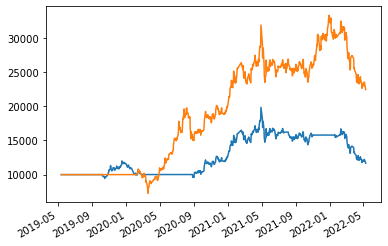

In [141]:
result_rsi_ema._equity_curve.Equity.plot()
result_opt_test._equity_curve.Equity.plot()

In [142]:
result_rsi_ema

Start                     2019-05-13 00:00:00
End                       2022-05-10 00:00:00
Duration                   1093 days 00:00:00
Exposure Time [%]                   59.807956
Equity Final [$]                 11678.928802
Equity Peak [$]                  19851.072723
Return [%]                          16.789288
Buy & Hold Return [%]              211.910671
Return (Ann.) [%]                    5.511502
Volatility (Ann.) [%]               29.637525
Sharpe Ratio                         0.185964
Sortino Ratio                         0.29542
Calmar Ratio                         0.133881
Max. Drawdown [%]                  -41.167266
Avg. Drawdown [%]                   -7.973646
Max. Drawdown Duration      376 days 00:00:00
Avg. Drawdown Duration       61 days 00:00:00
# Trades                                    4
Win Rate [%]                             50.0
Best Trade [%]                      65.221494
Worst Trade [%]                    -26.849315
Avg. Trade [%]                    

In [143]:
result_opt_test

Start                     2019-05-13 00:00:00
End                       2022-05-10 00:00:00
Duration                   1093 days 00:00:00
Exposure Time [%]                   75.308642
Equity Final [$]                  22449.06006
Equity Peak [$]                   33341.06006
Return [%]                         124.490601
Buy & Hold Return [%]              211.910671
Return (Ann.) [%]                   32.251874
Volatility (Ann.) [%]               49.993184
Sharpe Ratio                         0.645125
Sortino Ratio                        1.351819
Calmar Ratio                         0.981456
Max. Drawdown [%]                  -32.861243
Avg. Drawdown [%]                    -8.11264
Max. Drawdown Duration      242 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     124.753332
Worst Trade [%]                    124.753332
Avg. Trade [%]                    